In [ ]:
!pip install causalml
!pip install pyro-ppl

# CEVAE 코드 (predict 수정)

In [1]:

import logging
import torch
from pyro.contrib.cevae import CEVAE as CEVAEModel

from causalml.inference.meta.utils import convert_pd_to_np

pyro_logger = logging.getLogger("pyro")
pyro_logger.setLevel(logging.DEBUG)
if pyro_logger.handlers:
    pyro_logger.handlers[0].setLevel(logging.DEBUG)


class CEVAE:
    def __init__(
        self,
        outcome_dist="studentt",
        latent_dim=20,
        hidden_dim=200,
        num_epochs=50,
        num_layers=3,
        batch_size=100,
        learning_rate=1e-3,
        learning_rate_decay=0.1,
        num_samples=1000,
        weight_decay=1e-4,
    ):
        """
        Initializes CEVAE.

            Args:
                outcome_dist (str): Outcome distribution as one of: "bernoulli" , "exponential", "laplace", "normal",
                                    and "studentt"
                latent_dim (int) : Dimension of the latent variable
                hidden_dim (int) : Dimension of hidden layers of fully connected networks
                num_epochs (int): Number of training epochs
                num_layers (int): Number of hidden layers in fully connected networks
                batch_size (int): Batch size
                learning_rate (int): Learning rate
                learning_rate_decay (float/int): Learning rate decay over all epochs; the per-step decay rate will
                                                 depend on batch size and number of epochs such that the initial
                                                 learning rate will be learning_rate and the
                                                 final learning rate will be learning_rate * learning_rate_decay
                num_samples (int) : Number of samples to calculate ITE
                weight_decay (float) : Weight decay
        """
        self.outcome_dist = outcome_dist
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_epochs = num_epochs
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.num_samples = num_samples
        self.weight_decay = weight_decay

    def fit(self, X, treatment, y, p=None):
        """
        Fits CEVAE.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        """
        X, treatment, y = convert_pd_to_np(X, treatment, y)

        self.cevae = CEVAEModel(
            outcome_dist=self.outcome_dist,
            feature_dim=X.shape[-1],
            latent_dim=self.latent_dim,
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers,
        )

        self.cevae.fit(
            x=torch.tensor(X, dtype=torch.float),
            t=torch.tensor(treatment, dtype=torch.float),
            y=torch.tensor(y, dtype=torch.float),
            num_epochs=self.num_epochs,
            batch_size=self.batch_size,
            learning_rate=self.learning_rate,
            learning_rate_decay=self.learning_rate_decay,
            weight_decay=self.weight_decay,
        )

    def predict(self, X, treatment=None, y=None, p=None):
        """
        Calls predict on fitted DragonNet.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        return (
            self.cevae.ite(
                torch.tensor(X, dtype=torch.float),
                num_samples=self.num_samples,
                batch_size=self.batch_size,
            )
            # .cpu()
            .numpy()
        )

    def fit_predict(self, X, treatment, y, p=None):
        """
        Fits the CEVAE model and then predicts.

        Args:
            X (np.matrix or np.array or pd.Dataframe): a feature matrix
            treatment (np.array or pd.Series): a treatment vector
            y (np.array or pd.Series): an outcome vector
        Returns:
            (np.ndarray): Predictions of treatment effects.
        """
        self.fit(X, treatment, y)
        return self.predict(X)

ModuleNotFoundError: No module named 'pyro'

# CEVAE (Causal Effect Variational Autoencoder)
설명 자료 [Link](https://velog.io/@qtly_u/CEVAE-Causal-Effect-Inference-with-Deep-Latent-Variable-Models)


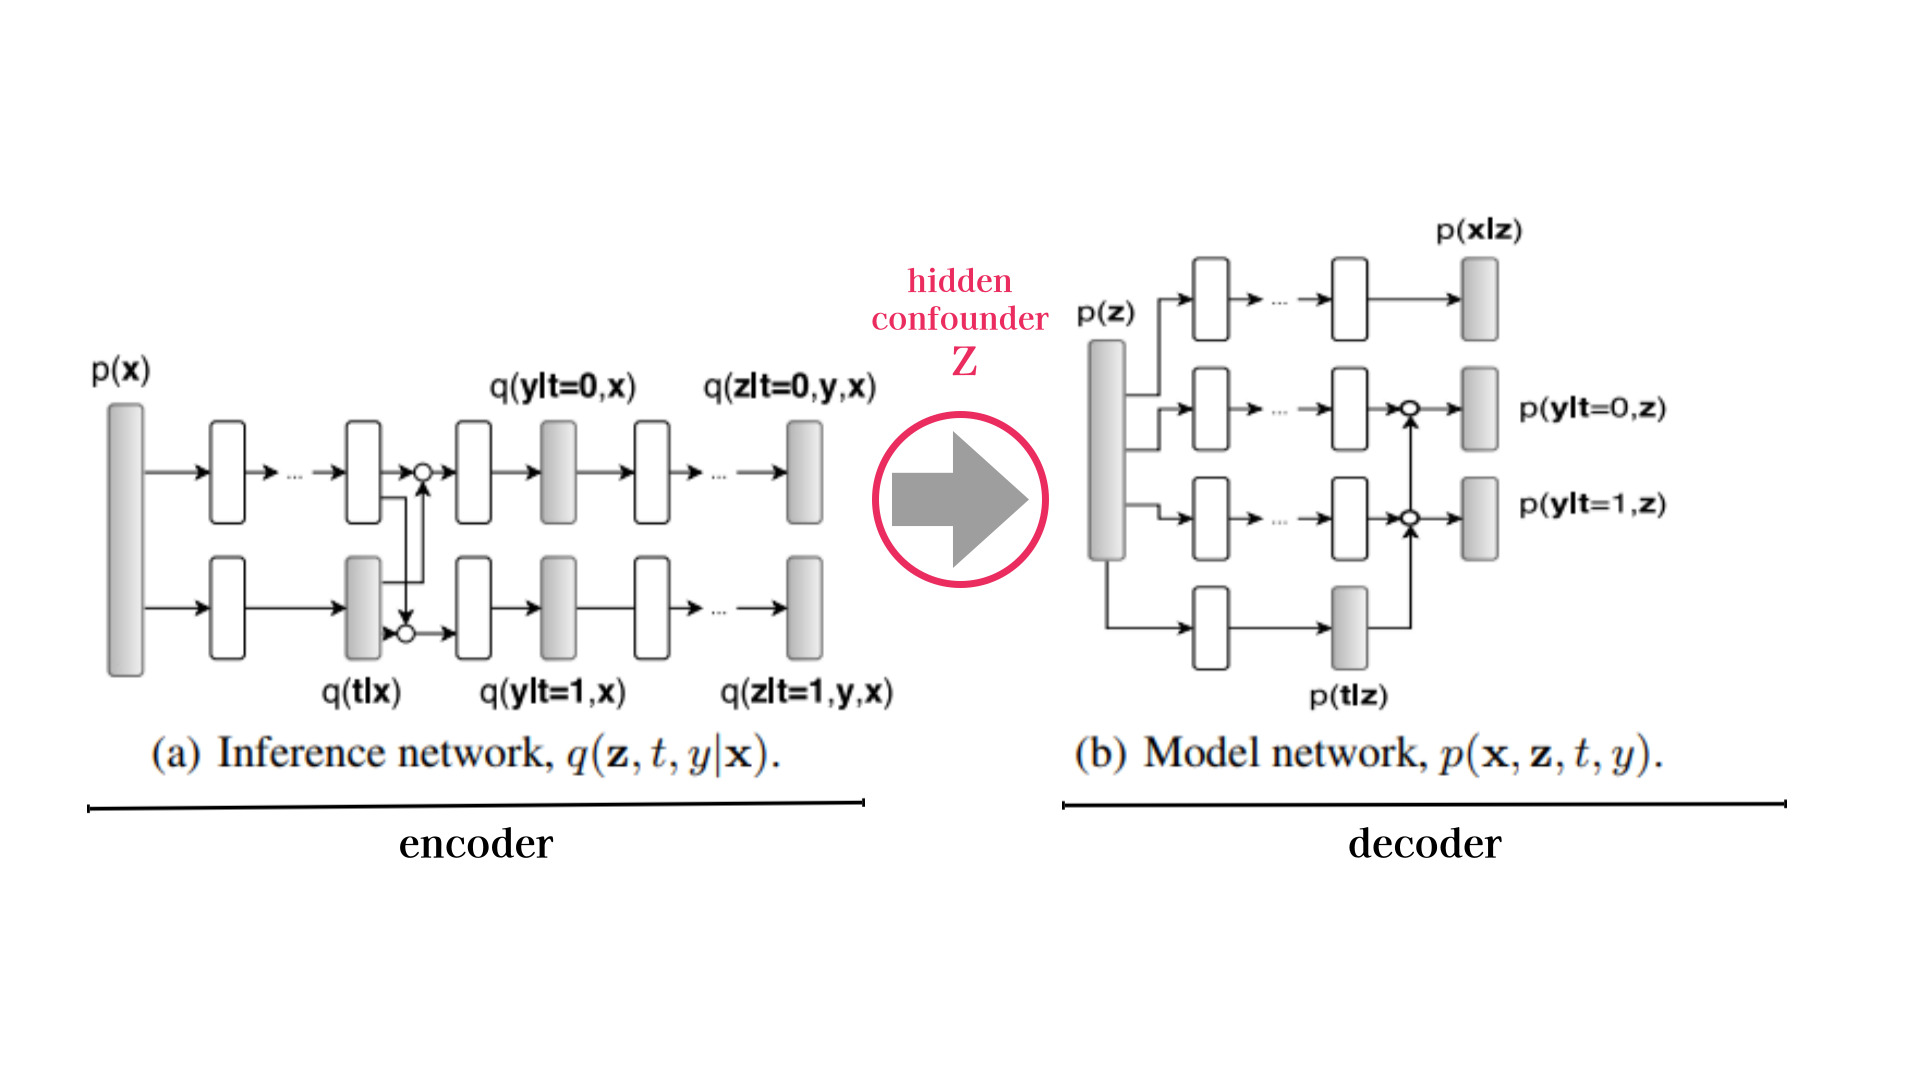

## 목적:
CEVAE는 관측 데이터만으로 개별 처치효과(ITE: Individual Treatment Effect)를 추정하는 모델

## VAE 구조를 사용하는 이유
관측된 데이터에는 보통 **혼란변수(confounder)**가 숨어 있고, 이 혼란변수를 직접 관측할 수 없는 경우가 많기 때문에 모델이 이를 **잠재변수(latent variable)**로 간주하고 추정 `(과연 x로 표현할 수 있을지는 모르겠음)`

여기서 VAE가 등장하는 이유:
VAE는 관측되지 않은 잠재 변수를 학습하고 재구성하는 데 강력한 도구이기 때문.

CEVAE는 **관측된 변수(X)**로부터 **잠재된 원인(Z)**를 추정하고,
이 Z를 이용해 **처치(T)**와 **결과(Y)**를 생성하려는 확률 모델을 생성

---
---

- X: 관측된 특징 정보 (예: 나이, 성별 등)
- T: 처치 여부 (예: 신약 복용 여부)
- Y: 결과 (예: 회복 여부 등)
- Z:  관측되지 않은 진짜 원인(인과적 구조를 설명하는 잠재 요인)


## 전체 모델 구조

인코더 (Inference model):
- 관측된 𝑋,𝑇,𝑌 로부터 잠재 변수 𝑍의 분포를 추정함
- 즉, 𝑞(𝑧∣𝑥,𝑡,𝑦)

디코더 (Generative model):
- 𝑍로부터 𝑋,𝑇,𝑌 를 생성하는 과정을 학습함
- 즉,𝑝(𝑥∣𝑧),𝑝(𝑡∣𝑧),𝑝(𝑦∣𝑧,𝑡)

이걸 통해 모델은 "Z라는 원인이 있었다면, 어떤 X가 나오고, T는 어떻게 선택되고, Y는 어떻게 결과가 되는가?"를 학습.

## 추론은 어떤 과정인지?
학습이 끝나면, 새로운 사람에 대해:

그 사람의 𝑋를 가지고, 잠재 변수 𝑍를 추정하고,

각각 𝑇=1, 𝑇=0일 때의 결과 𝑌 를 예측해서 두 결과의 차이를 ITE로 추정.

즉:
𝐼𝑇𝐸(𝑥)=𝑦(𝑡=1,𝑥)−𝑦(𝑡=0,𝑥)


## 결국.
"잠재된 원인(Z)을 모델이 유추해서 X, T, Y를 설명한다"

"모델이 학습한 Z를 바탕으로 T=1과 T=0의 결과 차이를 예측한다"

In [10]:
# from causalml.inference.torch import CEVAE
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.torch import CEVAE
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

from lightgbm import LGBMRegressor

# IHDP semi-synthetic dataset

Hill introduced a semi-synthetic dataset constructed from the Infant Health and Development Program.

"힐"은 영아 건강 및 발달 프로그램(IHDP)에서 구축된 반합성 데이터 세트를 소개했습니다. 이 데이터 세트는 전문가의 가정 방문이 향후 인지 점수에 미치는 영향을 조사하는 무작위 실험에 기반합니다. IHDP 시뮬레이션은 신경망 치료 효과 추정 방법의 사실상 표준 벤치마크로 간주됩니다.

인지 능력 점수에 미치는 영향을 확인하기 위한 데이터 셋.

In [4]:
# load all ihdp data
df_raw = pd.DataFrame()
for i in range(1, 10):
    url = f"""https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_{i}.csv"""
    data= pd.read_csv(url, header = None)
    df_raw = pd.concat([data, df_raw])
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
df_raw.columns = cols
print(df_raw.shape)

# Deep Learning 학습을 위해 100배 복제
replications = 100
df = pd.concat([df_raw]*replications, ignore_index=True).reset_index(drop=True)
print(df.shape)

(6723, 30)
(672300, 30)


In [5]:
# 이진형 변수
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
# 연속형 변수
contfeats = [i for i in range(25) if i not in binfeats]

# reorder features
perm = binfeats + contfeats
df = df.reset_index(drop=True)
df.head()

# 반 사실 결과를 확인할 수 있는 벤치마크 데이터셋 입니다.

,treatment,y_factual,y_cfactual,mu0,mu1,0,1,2,3,4,...,15,16,17,18,19,20,21,22,23,24
0,1,49.647921,34.950762,37.173291,50.383798,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,16.073412,49.435313,16.087249,49.546234,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,19.643007,48.598210,18.044855,49.661068,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,26.368322,49.715204,24.605964,49.971196,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,20.258893,51.147418,20.612816,49.794120,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [6]:
# 딥러닝 학습용
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1
               else d['y_cfactual'] - d['y_factual'],
               axis=1).reset_index(drop=True)
# seperate for train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr]



# 예측용 데이터 셋 (딥러닝 학습 예측셋이 너무 크다)
X = df_raw[perm].values
treatment = df_raw['treatment'].values
y = df_raw['y_factual'].values
y_cf = df_raw['y_cfactual'].values
tau = df_raw.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1
               else d['y_cfactual'] - d['y_factual'],
               axis=1).reset_index(drop=True)
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train_raw, treatment_train_raw, y_train_raw, y_cf_train_raw, tau_train_raw = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val= X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite]

In [7]:
# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000 * 2
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2

In [8]:
cevae = CEVAE(outcome_dist=outcome_dist,
              latent_dim=latent_dim,
              hidden_dim=hidden_dim,
              num_epochs=num_epochs,
              batch_size=batch_size,
              learning_rate=learning_rate,
              learning_rate_decay=learning_rate_decay,
              num_layers=num_layers)

In [9]:
# fit (2분))
losses = cevae.fit(
    X=torch.tensor(X_train, dtype=torch.float),
    treatment=torch.tensor(treatment_train, dtype=torch.float),
    y=torch.tensor(y_train, dtype=torch.float)
)


INFO:pyro.contrib.cevae:Training with 269 minibatches per epoch
DEBUG:pyro.contrib.cevae:step     0 loss = 752.302
DEBUG:pyro.contrib.cevae:step   100 loss = 36.1147
DEBUG:pyro.contrib.cevae:step   200 loss = 23.3251
DEBUG:pyro.contrib.cevae:step   300 loss = 18.5594
DEBUG:pyro.contrib.cevae:step   400 loss = 14.9276
DEBUG:pyro.contrib.cevae:step   500 loss = 13.4495
DEBUG:pyro.contrib.cevae:step   600 loss = 12.0499
DEBUG:pyro.contrib.cevae:step   700 loss = 10.1288
DEBUG:pyro.contrib.cevae:step   800 loss = 9.8599
DEBUG:pyro.contrib.cevae:step   900 loss = 8.9111
DEBUG:pyro.contrib.cevae:step  1000 loss = 9.0098
DEBUG:pyro.contrib.cevae:step  1100 loss = 8.08949
DEBUG:pyro.contrib.cevae:step  1200 loss = 8.33889
DEBUG:pyro.contrib.cevae:step  1300 loss = 8.70999


In [11]:
# predict (2분)
ite_train = cevae.predict(X_train_raw) #.cpu()
ite_val = cevae.predict(X_val)

INFO:pyro.contrib.cevae:Evaluating 3 minibatches
DEBUG:pyro.contrib.cevae:batch ate = 3.19685
DEBUG:pyro.contrib.cevae:batch ate = 3.1681
DEBUG:pyro.contrib.cevae:batch ate = 3.28275
INFO:pyro.contrib.cevae:Evaluating 1 minibatches
DEBUG:pyro.contrib.cevae:batch ate = 3.20532


In [12]:
ate_train = ite_train.mean()
ate_val = ite_val.mean()
print(ate_train, ate_val)

3.2081695 3.2053177


# 메타 러너와 비교

In [13]:
# fit propensity model
p_model = ElasticNetPropensityModel()
p_train = p_model.fit_predict(X_train_raw, treatment_train_raw)
p_val = p_model.fit_predict(X_val, treatment_val)

In [14]:
s_learner = BaseSRegressor(LGBMRegressor(verbose=-1))
s_ate = s_learner.estimate_ate(X_train_raw, treatment_train_raw, y_train_raw)[0]
s_ite_train = s_learner.fit_predict(X_train_raw, treatment_train_raw, y_train_raw)
s_ite_val = s_learner.predict(X_val)

t_learner = BaseTRegressor(LGBMRegressor(verbose=-1))
t_ate = t_learner.estimate_ate(X_train_raw, treatment_train_raw, y_train_raw)[0][0]
t_ite_train = t_learner.fit_predict(X_train_raw, treatment_train_raw, y_train_raw)
t_ite_val = t_learner.predict(X_val, treatment_val, y_val)

x_learner = BaseXRegressor(LGBMRegressor(verbose=-1))
x_ate = x_learner.estimate_ate(X_train_raw, treatment_train_raw, y_train_raw, p_train)[0][0]
x_ite_train = x_learner.fit_predict(X_train_raw, treatment_train_raw, y_train_raw, p_train)
x_ite_val = x_learner.predict(X_val, treatment_val, y_val, p_val)

r_learner = BaseRRegressor(LGBMRegressor(verbose=-1))
r_ate = r_learner.estimate_ate(X_train_raw, treatment_train_raw, y_train_raw, p_train)[0][0]
r_ite_train = r_learner.fit_predict(X_train_raw, treatment_train_raw, y_train_raw, p_train)
r_ite_val = r_learner.predict(X_val)

# Model Results Comparsion
## Training

In [15]:
df_preds_train = pd.DataFrame([s_ite_train.ravel(),
                               t_ite_train.ravel(),
                               x_ite_train.ravel(),
                               r_ite_train.ravel(),
                               ite_train.ravel(),
                               tau_train_raw.ravel(),
                               treatment_train_raw.ravel(),
                               y_train_raw.ravel()],
                               index=['S','T','X','R','CEVAE','tau','w','y']).T

df_cumgain_train = get_cumgain(df_preds_train)

In [16]:
df_result_train = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, ate_train, tau_train_raw.mean()],
                               index=['S','T','X','R','CEVAE','actual'], columns=['ATE'])
df_result_train['MAE'] = [mean_absolute_error(t,p) for t,p in zip([s_ite_train, t_ite_train, x_ite_train, r_ite_train, ite_train],
                                                                  [tau_train_raw.values.reshape(-1,1)]*5 )
                          ] + [None]
df_result_train['AUUC'] = auuc_score(df_preds_train)

In [17]:
df_result_train

,ATE,MAE,AUUC
S,4.661763,4.533111,0.664618
T,4.639223,5.068461,0.641973
X,4.711447,4.575492,0.646738
R,0.946511,6.142228,0.552620
CEVAE,3.208169,4.975471,0.568401
actual,4.809767,NaN,NaN


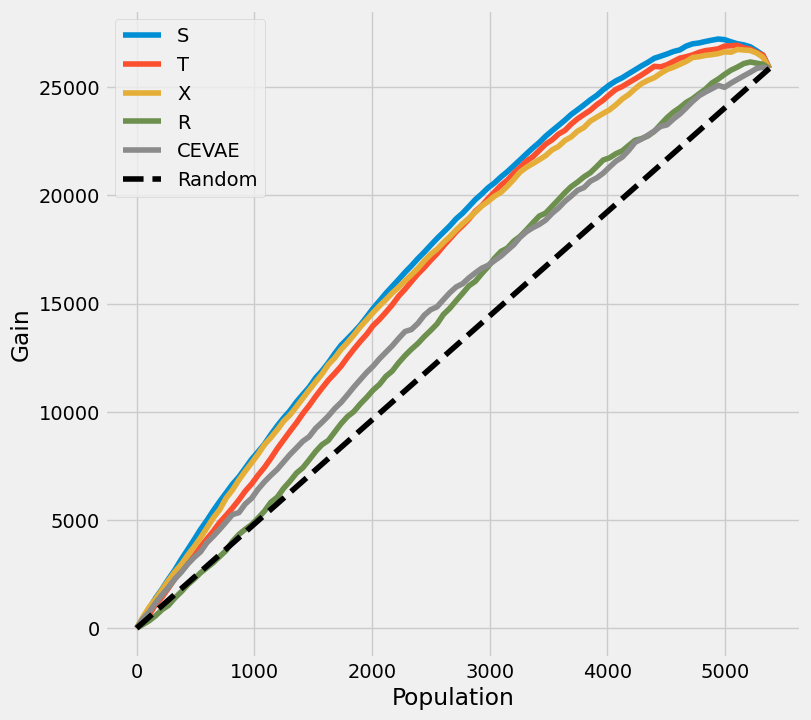

In [18]:
plot_gain(df_preds_train)

In [19]:
# 예측값 중, 차이가 가장 큰 항목 확인 (3,695 행)
diff = s_ite_train.ravel() - ite_train.ravel()
diff_max_idx = diff.argmax() # 3,695 행
diff_max_idx

np.int64(3695)

In [20]:
X_train_raw#, treatment_train_raw, y_train_raw, y_cf_train_raw, tau_train_raw
q1 = pd.DataFrame(X_train_raw)
q2 = pd.DataFrame(treatment_train_raw, columns=['treatment'])
q3 = pd.DataFrame(y_train_raw.ravel(), columns=['y_factual'])
q4 = pd.DataFrame(tau_train_raw.ravel(), columns=['tau_train_raw'])

df_train_raw = pd.concat([q1, q2, q3, q4], axis = 1)
df_train_raw['s_leaner'] = s_ite_train.ravel()
df_train_raw['cevae'] = ite_train.ravel()

In [21]:
df_train_raw.iloc[diff_max_idx]
# CEVAE는 음수로 추정

,3695
0,1.000000
1,0.000000
2,1.000000
3,0.000000
4,0.000000
5,1.000000
6,0.000000
7,2.000000
8,0.000000
9,1.000000
